In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
X = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1]


df_train.head(3)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0


In [3]:
df_train.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [5]:
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("\nNumerical Columns:")
print(numerical_columns)
print(f"\nTotal number of numerical columns: {len(numerical_columns)}")

print("\nCategorical Columns:")
print(categorical_columns)
print(f"\nTotal number of categorical columns: {len(categorical_columns)}")


Numerical Columns:
['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']

Total number of numerical columns: 9

Categorical Columns:
['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

Total number of categorical columns: 11


In [6]:
df_train[numerical_columns] = df_train[numerical_columns].fillna(df_train[numerical_columns].mean())
df_test[numerical_columns] = df_test[numerical_columns].fillna(df_test[numerical_columns].mean())

In [7]:
df_train[categorical_columns] = df_train[categorical_columns].fillna("Missing")
df_test[categorical_columns] = df_test[categorical_columns].fillna("Missing")

In [8]:
df_train.isnull().sum()

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

In [9]:
df_train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

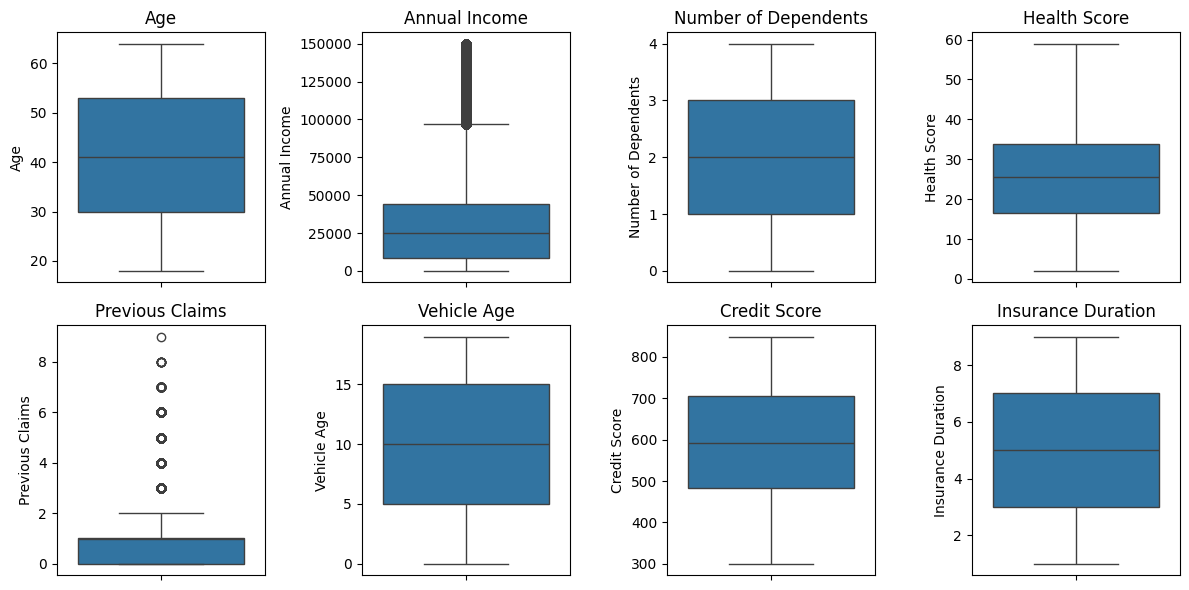

In [10]:
features=['Age','Annual Income','Number of Dependents','Health Score','Previous Claims','Vehicle Age','Credit Score','Insurance Duration']
plt.figure(figsize=(12, 6))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)  # Adjust grid size based on the number of features
    sns.boxplot(y=df_train[feature])  # Replace train_dataset with your actual dataset
    plt.title(feature)

plt.tight_layout()
plt.show()

In [11]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from 'Annual Income' and 'Previous Claims'
df_train = remove_outliers(df_train, 'Annual Income')
df_train = remove_outliers(df_train, 'Previous Claims')

# Check the dataset after removing outliers
print(df_train.shape)

(1072844, 21)


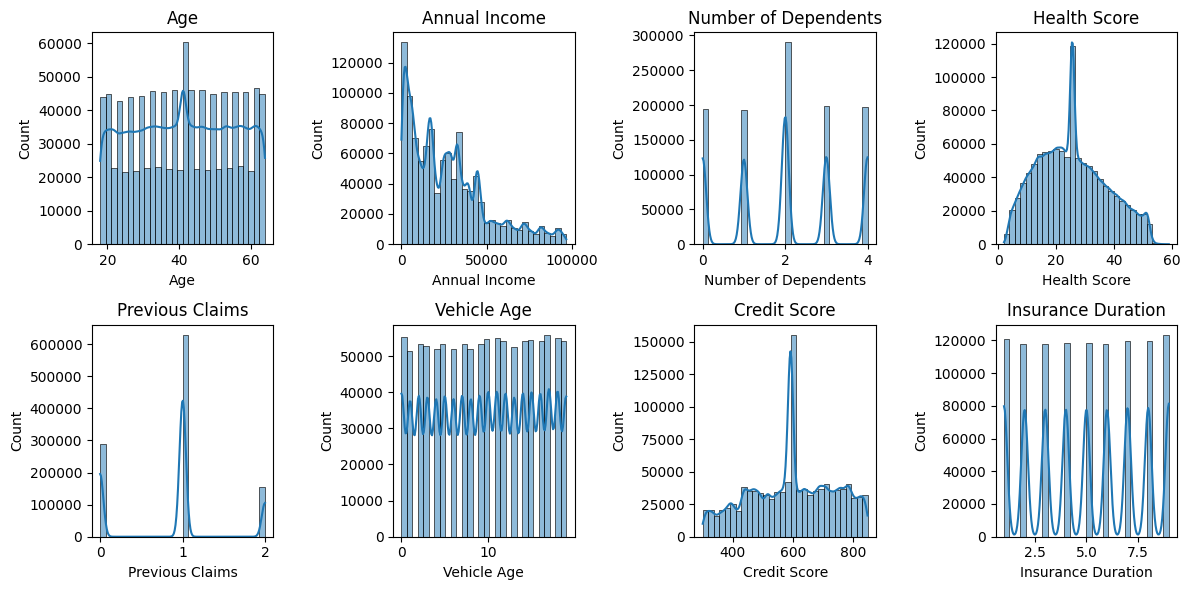

In [12]:
plt.figure(figsize=(12, 6))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)  # Adjust grid size based on the number of features
    sns.histplot(df_train[feature], bins=30, kde=True)  # KDE=True adds a density curve
    plt.title(feature)

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

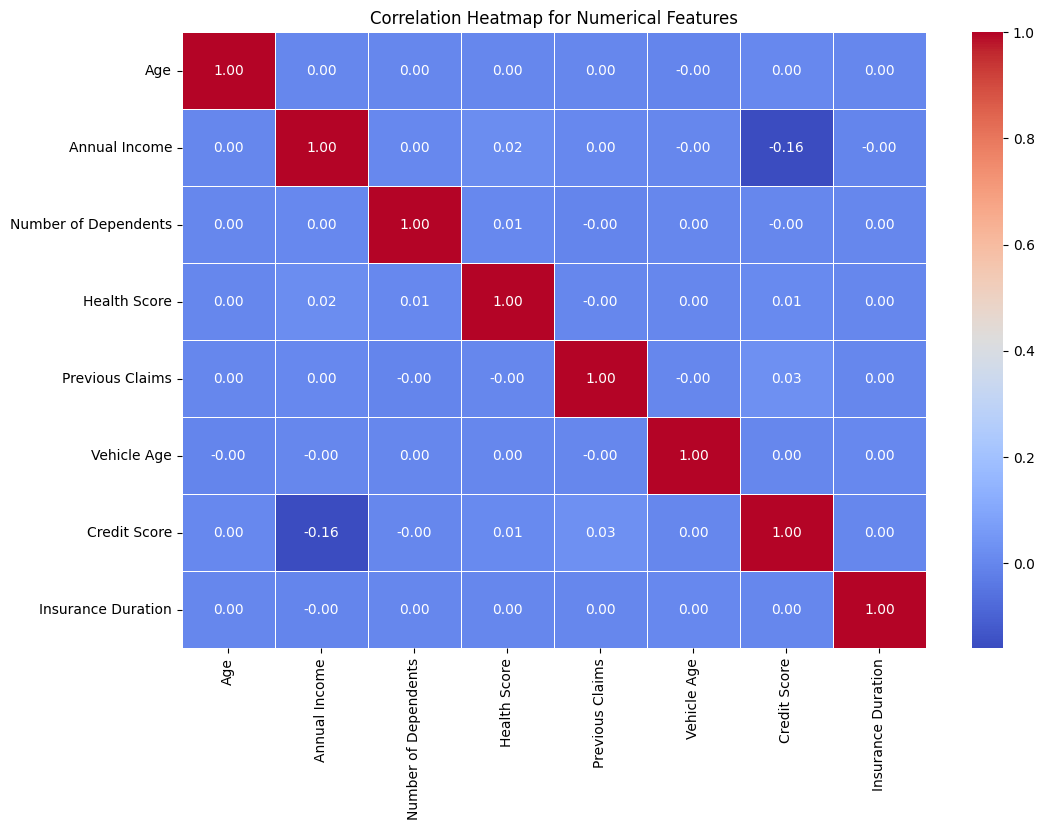

In [13]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

corr_matrix = df_train[features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the heatmap
plt.title('Correlation Heatmap for Numerical Features')
plt.show()


In [15]:
featues_categorical = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']